In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import qriemannopt as qro
from MERAOpt import MERAOpt

C:\Users\HYPERPC\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


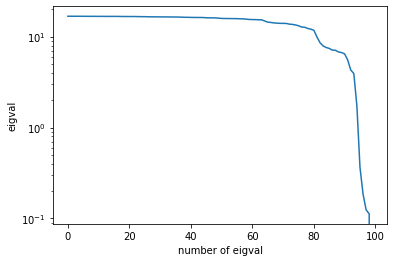

In [2]:
ham_dim = 100 # dimension of hamiltonian
renorm_ham_dim = 30 # dimension of renormalized hamiltonian

# hamiltonian
Q = qro.manifold.real_to_complex(tf.random.normal((ham_dim, ham_dim, 2), dtype=tf.float64))
Q, _ = tf.linalg.qr(Q)
S = tf.random.uniform((ham_dim,), -3, 3)
S = tf.exp(S)
S = tf.cast(S - tf.reduce_max(S), dtype=tf.complex128)
H = tf.einsum('ik,k,jk->ij', Q, S, tf.math.conj(Q))

plt.plot(-tf.linalg.eigvalsh(H))
plt.yscale('log')
plt.xlabel('number of eigval')
plt.ylabel('eigval')

# isometric matrix
q_in = tf.complex(tf.random.normal((ham_dim, renorm_ham_dim), dtype=tf.float64),
               tf.random.normal((ham_dim, renorm_ham_dim), dtype=tf.float64))
q_in, _ = tf.linalg.qr(q_in)
q_in = qro.manifold.complex_to_real(q_in)

# min of loss function
min_value = tf.cast(tf.reduce_sum(tf.linalg.eigvalsh(H)[:renorm_ham_dim]),
                   dtype=tf.float64)

# riemannian optimizaers
m_cayley = qro.manifold.StiefelManifold(retraction='cayley')
m_svd = qro.manifold.StiefelManifold()
opts = {
        'GD_cayley':qro.optimizers.RSGD(m_cayley, 0.003),
        'GD_svd':qro.optimizers.RSGD(m_svd, 0.003),
        'GD_cayley_with_momentum':qro.optimizers.RSGD(m_cayley, 0.05, 0.9),
        'GD_svd_with_momentum':qro.optimizers.RSGD(m_svd, 0.05, 0.9),
        'Adam_cayley':qro.optimizers.RAdam(m_cayley, 0.03),
        'Adam_svd':qro.optimizers.RAdam(m_svd, 0.03),
        'Adam_cayley_with_ams':qro.optimizers.RAdam(m_cayley, 0.03, ams=True),
        'Adam_svd_with_ams':qro.optimizers.RAdam(m_svd, 0.03, ams=True),
        'MERAOpt': MERAOpt()
       }

In [3]:
list_of_losses = {}
# loop over optimizers
for key, opt in opts.items():
    # training loop
    losses = []
    q = tf.Variable(q_in)
    for _ in range(1000):
        with tf.GradientTape() as tape:
            Z = tf.complex(q[..., 0], q[..., 1])
            loss = tf.cast(tf.linalg.trace((tf.linalg.adjoint(Z) @ H @ Z)),
                        dtype=tf.float64)
            losses.append(loss - min_value)
        grad = tape.gradient(loss, q)
        opt.apply_gradients(zip([grad], [q]))
    list_of_losses[key] = losses

Text(0, 0.5, 'err')

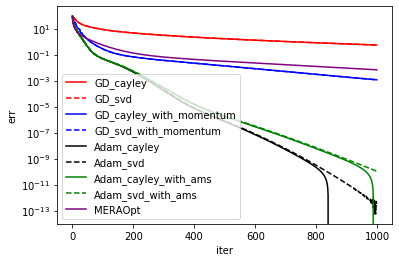

In [4]:
# learning curves
colors = ['r', 'r--', 'b', 'b--', 'k', 'k--', 'g', 'g--', 'purple']
plt.figure()
for i, key in enumerate(opts.keys()):
    plt.plot(list_of_losses[key], colors[i])
plt.legend(opts.keys())
plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('err')